In [72]:
pip install yfinance 

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable



In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout , LSTM  , BatchNormalization , Input
import datetime as dt
from datetime import datetime
import yfinance as yf

In [74]:
company = 'META'
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)

data = yf.download(company, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [75]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,META,META,META,META,META
Date,,,,,
2012-05-18,38.084522,44.828761,37.855398,41.889986,573576400
2012-05-21,33.900501,36.520494,32.874422,36.390988,168192700
2012-05-22,30.882032,33.462177,30.822261,32.485906,101786600
2012-05-23,31.878227,32.376325,31.240663,31.250625,73600000
2012-05-24,32.904305,33.083620,31.649101,32.824611,50237200


In [76]:
data.corr()

,Price,Close,High,Low,Open,Volume
,Ticker,META,META,META,META,META
Price,Ticker,,,,,
Close,META,1.000000,0.999770,0.999803,0.999542,-0.467422
High,META,0.999770,1.000000,0.999691,0.999804,-0.462329
Low,META,0.999803,0.999691,1.000000,0.999725,-0.471788
Open,META,0.999542,0.999804,0.999725,1.000000,-0.466216
Volume,META,-0.467422,-0.462329,-0.471788,-0.466216,1.000000


<Axes: xlabel='Price-Ticker', ylabel='Price-Ticker'>

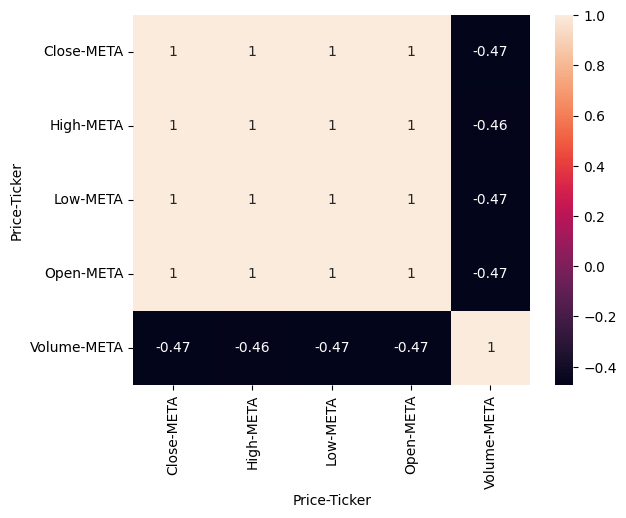

In [77]:
sns.heatmap(data.corr(), annot=True)

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1917 entries, 2012-05-18 to 2019-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, META)   1917 non-null   float64
 1   (High, META)    1917 non-null   float64
 2   (Low, META)     1917 non-null   float64
 3   (Open, META)    1917 non-null   float64
 4   (Volume, META)  1917 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 89.9 KB


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1917 entries, 2012-05-18 to 2019-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, META)   1917 non-null   float64
 1   (High, META)    1917 non-null   float64
 2   (Low, META)     1917 non-null   float64
 3   (Open, META)    1917 non-null   float64
 4   (Volume, META)  1917 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 89.9 KB


In [80]:
data.duplicated().sum()

0

In [81]:
data.shape

(1917, 5)

Text(0, 0.5, 'Volume')

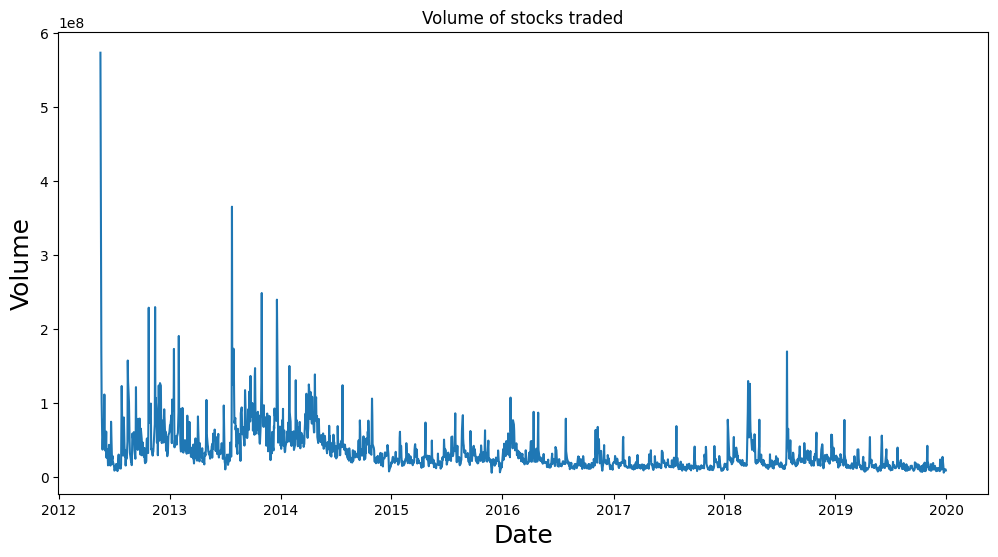

In [82]:
# plotting volume over time 
plt.figure(figsize=(12,6))
plt.title('Volume of stocks traded')        
plt.plot(data['Volume'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Volume', fontsize=18)

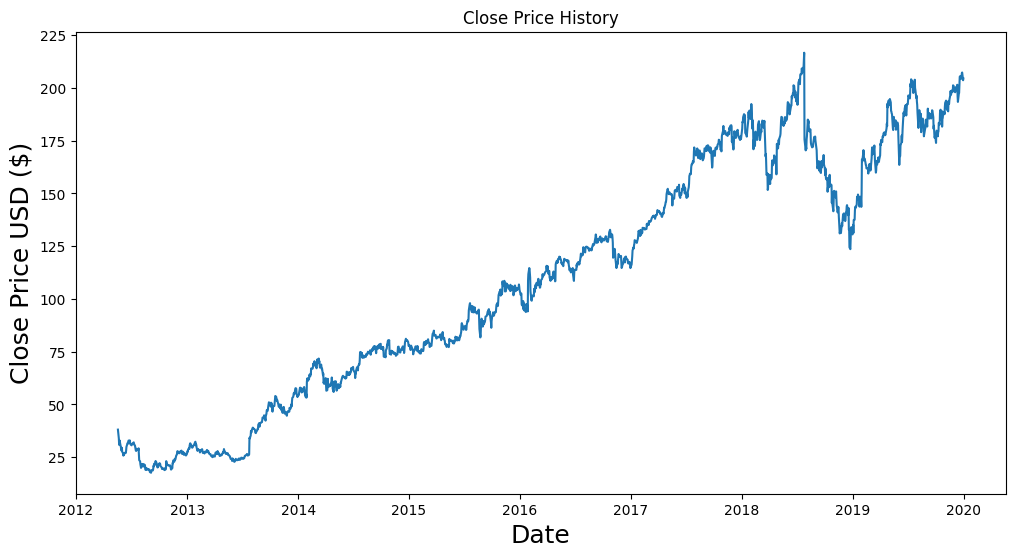

In [83]:
# plotting closing price over time
plt.figure(figsize=(12,6))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

# preparing the data 

In [84]:
data.columns

MultiIndex([( 'Close', 'META'),
            (  'High', 'META'),
            (   'Low', 'META'),
            (  'Open', 'META'),
            ('Volume', 'META')],
           names=['Price', 'Ticker'])

In [85]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1)) # reshaping the data as the input to the scaler must be 2D

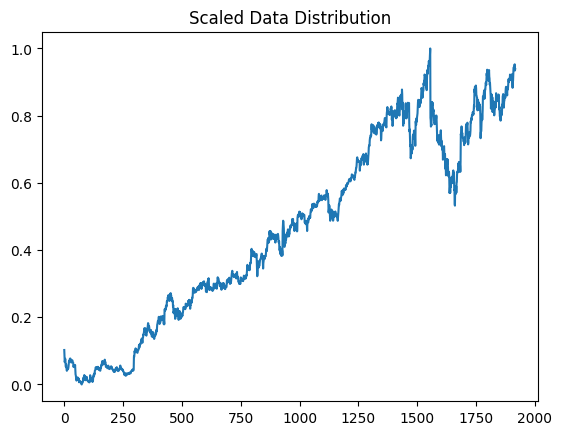

In [86]:
import matplotlib.pyplot as plt

plt.plot(scaled_data)
plt.title("Scaled Data Distribution")
plt.show()


In [87]:
prediction_days = 30
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

In [88]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [89]:
x_train.shape

(1887, 30, 1)

# training the model 

In [90]:
# Build LSTM model
# we did not use batch normalization because we were getting a normalized plot and it was not giving the actual  stock price  
model = Sequential([
    # input layer 
    Input(shape=(x_train.shape[1], 1)),
    LSTM(units=256, return_sequences=True, activation='relu'),
    Dropout(0.5),
    # layer 2 
    LSTM(units=128, return_sequences=True, activation='relu'),
    Dropout(0.2),
    # layer 3
    LSTM(units=64, return_sequences=False, activation='relu'),
    Dropout(0.1),
    # output layer
    Dense(units=1)  # Predict next closing price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

print(model.summary())

# Train the model
history = model.fit(
    x_train, y_train, 
    epochs=50,  
    batch_size=64, 
    validation_split=0.1,
    verbose=1
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 30, 256)             │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 30, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 510,785 (1.95 MB)

 Trainable params: 510,785 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - loss: 0.1356 - val_loss: 0.0048
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.0022 - val_loss: 0.0060
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/st

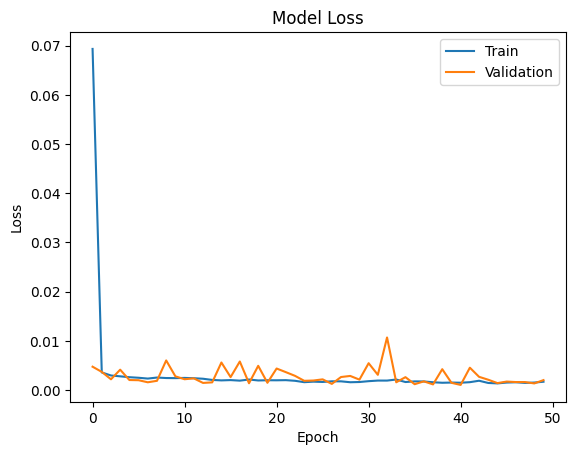

In [91]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# plotting the predicted prices on next unknown days

In [92]:
# Download test data
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime.now()
test_data = yf.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values


# Prepare model input for predictions
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

[*********************100%***********************]  1 of 1 completed


In [93]:
# Create test sequences
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [94]:
# Make predictions
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices) # inversing as we dont need normalized data anymore

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


In [95]:
predicted_prices.shape

(1300, 1)

# plotting test predictions 

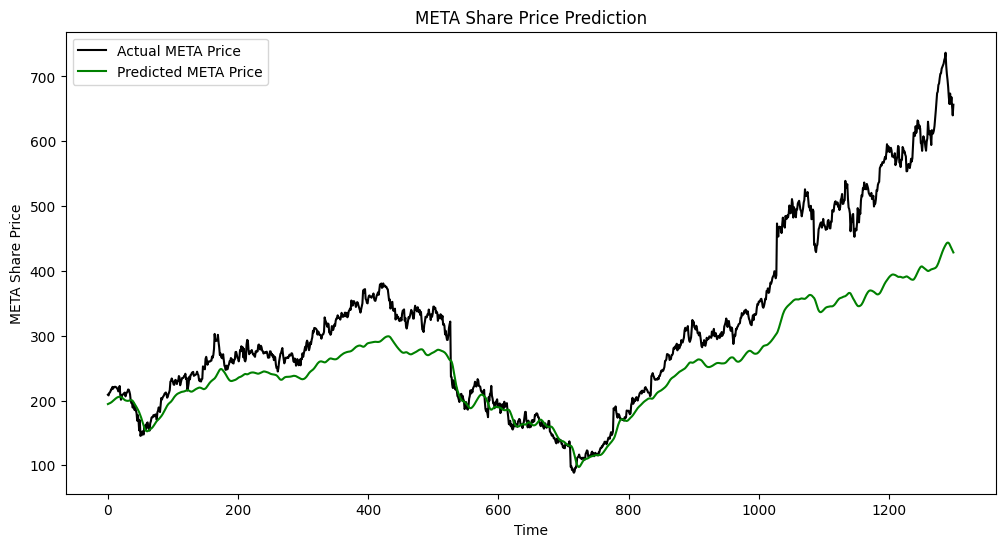

In [96]:
# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(actual_prices, color='black', label=f'Actual {company} Price')
plt.plot(predicted_prices, color='green', label=f'Predicted {company} Price')
plt.title(f'{company} Share Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()


# predict next day 

In [97]:
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days : len(model_inputs + 1) , 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data , (real_data.shape[0] , real_data.shape[1] , 1))

In [98]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction : {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
prediction : [[426.63654]]
